In [7]:
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame

def scale_all_dataframe(data: DataFrame) -> DataFrame:
    vars: list[str] = data.columns.to_list()
    transf: StandardScaler = StandardScaler().fit(data)
    df = DataFrame(transf.transform(data), index=data.index)
    df.columns = vars
    return df

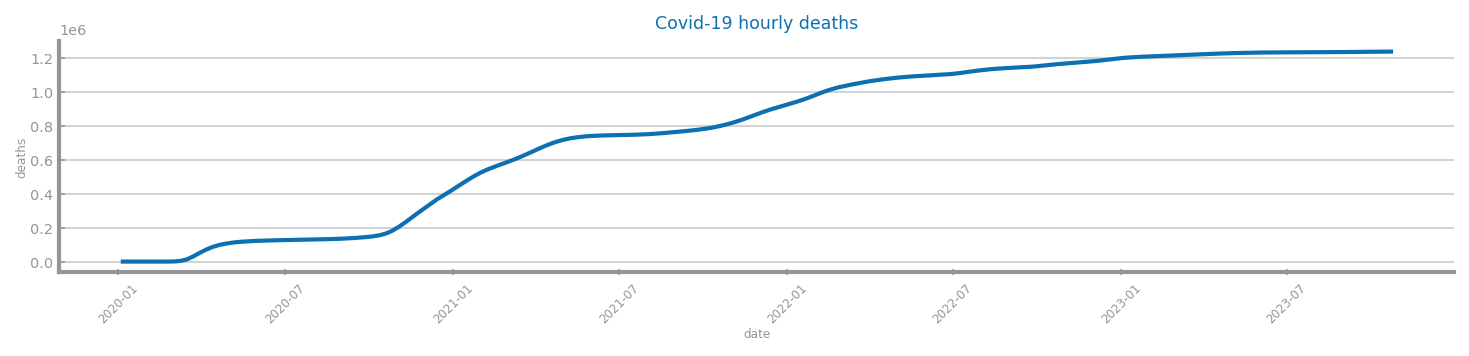

In [8]:
from pandas import read_csv, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_line_chart, HEIGHT

file_tag = "Covid-19"
filename = "data/time_series/forecast_covid_single.csv"
index = "date"
target = "deaths"
timecol = "date"
data: DataFrame = read_csv(
    filename,
    index_col=index,
    sep=",",
    decimal=".",
    parse_dates=True,
    infer_datetime_format=True,
)
series: Series = data[target]

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} hourly {target}",
)
show()

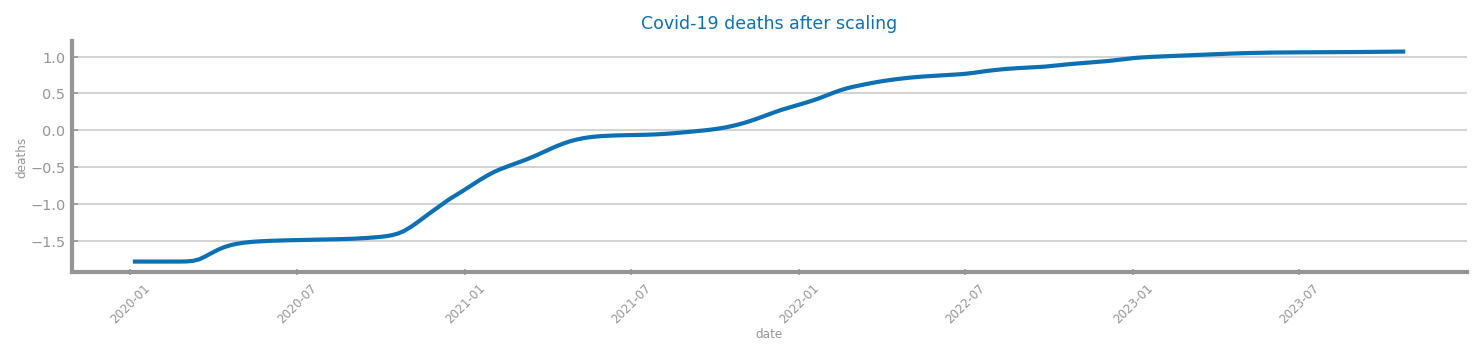

In [9]:
df: DataFrame = scale_all_dataframe(data)

ss: Series = df[target]
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    ss.index.to_list(),
    ss.to_list(),
    xlabel=ss.index.name,
    ylabel=target,
    title=f"{file_tag} {target} after scaling",
)
show()

# Plot makers

In [10]:
from matplotlib.axes import Axes
from matplotlib.pyplot import subplots
from numpy import sqrt
from config import FUTURE_COLOR, PAST_COLOR, PRED_FUTURE_COLOR
from dslabs_functions import FORECAST_MEASURES, plot_multibar_chart


def plot_forecasting_eval(trn: Series, tst: Series, prd_trn: Series, prd_tst: Series, title: str = "", axs = None) -> list[Axes]:
    ev1: dict = {
        "RMSE": [sqrt(FORECAST_MEASURES["MSE"](trn, prd_trn)), sqrt(FORECAST_MEASURES["MSE"](tst, prd_tst))],
        "MAE": [FORECAST_MEASURES["MAE"](trn, prd_trn), FORECAST_MEASURES["MAE"](tst, prd_tst)],
    }
    ev2: dict = {
        "MAPE": [FORECAST_MEASURES["MAPE"](trn, prd_trn), FORECAST_MEASURES["MAPE"](tst, prd_tst)],
        "R2": [FORECAST_MEASURES["R2"](trn, prd_trn), FORECAST_MEASURES["R2"](tst, prd_tst)],
    }

    # print(eval1, eval2)
    if axs is None:
        fig, axs = subplots(1, 2, figsize=(1.5 * HEIGHT, 0.75 * HEIGHT), squeeze=True)
        fig.suptitle(title)
    else:
        axs[0].set_title(title)
    if title != "":
        title = f"({title})"
    plot_multibar_chart(["train", "test"], ev1, ax=axs[0], title=f"Scale-dependent error {title}", percentage=False)
    plot_multibar_chart(["train", "test"], ev2, ax=axs[1], title=f"Percentage error {title}", percentage=True)

    return axs

def plot_forecasting_series(
    trn: Series,
    tst: Series,
    prd_tst: Series,
    title: str = "",
    xlabel: str = "time",
    ylabel: str = "",
    ax = None
) -> list[Axes]:
    if ax is None:
        fig, ax = subplots(1, 1, figsize=(4 * HEIGHT, HEIGHT), squeeze=True)
        fig.suptitle(title)
    else:
        ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(trn.index, trn.values, label="train", color=PAST_COLOR)
    ax.plot(tst.index, tst.values, label="test", color=FUTURE_COLOR)
    ax.plot(prd_tst.index, prd_tst.values, "--", label="test prediction", color=PRED_FUTURE_COLOR)
    ax.legend(prop={"size": 5})

    return ax

# Linear Regression

In [11]:
from numpy import arange
from pandas import DataFrame, Series
from sklearn.linear_model import LinearRegression
from dslabs_functions import series_train_test_split


def lin(agg_df):
    train, test = series_train_test_split(agg_df, trn_pct=0.90)

    trnX = arange(len(train)).reshape(-1, 1)
    trnY = train.to_numpy()
    tstX = arange(len(train), len(agg_df)).reshape(-1, 1)
    tstY = test.to_numpy()

    model = LinearRegression()
    model.fit(trnX, trnY)

    prd_trn: Series = Series(model.predict(trnX), index=train.index)
    prd_tst: Series = Series(model.predict(tstX), index=test.index)

    return train, test, prd_trn, prd_tst




# Simple Average

In [12]:
def simple(data):
    train, test = series_train_test_split(data, trn_pct=0.90)

    from sklearn.base import RegressorMixin


    class SimpleAvgRegressor(RegressorMixin):
        def __init__(self):
            super().__init__()
            self.mean: float = 0.0
            return

        def fit(self, X: Series):
            self.mean = X.mean()
            return

        def predict(self, X: Series) -> Series:
            prd: list = len(X) * [self.mean]
            prd_series: Series = Series(prd)
            prd_series.index = X.index
            return prd_series

    fr_mod = SimpleAvgRegressor()
    fr_mod.fit(train)
    prd_trn: Series = fr_mod.predict(train)
    prd_tst: Series = fr_mod.predict(test)

    return train, test, prd_trn, prd_tst

# Persistence

In [13]:
from pandas import Series
from sklearn.base import RegressorMixin

def persistence_optimist(data):


    class PersistenceOptimistRegressor(RegressorMixin):
        def __init__(self):
            super().__init__()
            self.last: float = 0.0
            return

        def fit(self, X: Series):
            self.last = X.iloc[-1]
            # print(self.last)
            return

        def predict(self, X: Series):
            prd: list = X.shift().values.ravel()
            prd[0] = self.last
            prd_series: Series = Series(prd)
            prd_series.index = X.index
            return prd_series
    
    train, test = series_train_test_split(data, trn_pct=0.90)

    fr_mod = PersistenceOptimistRegressor()
    fr_mod.fit(train)
    prd_trn: Series = fr_mod.predict(train)
    prd_tst: Series = fr_mod.predict(test)

    return train, test, prd_trn, prd_tst

def persistence_realist(data):

    class PersistenceRealistRegressor(RegressorMixin):
        def __init__(self):
            super().__init__()
            self.last = 0
            self.estimations = [0]
            self.obs_len = 0

        def fit(self, X: Series):
            for i in range(1, len(X)):
                self.estimations.append(X.iloc[i - 1])
            self.obs_len = len(self.estimations)
            self.last = X.iloc[len(X) - 1]
            prd_series: Series = Series(self.estimations)
            prd_series.index = X.index
            return prd_series

        def predict(self, X: Series):
            prd: list = len(X) * [self.last]
            prd_series: Series = Series(prd)
            prd_series.index = X.index
            return prd_series
    
    train, test = series_train_test_split(data, trn_pct=0.90)

    fr_mod = PersistenceRealistRegressor()
    fr_mod.fit(train)
    prd_trn: Series = fr_mod.predict(train)
    prd_tst: Series = fr_mod.predict(test)

    return train, test, prd_trn, prd_tst

# Rolling Mean

In [14]:
from matplotlib.pyplot import savefig

def rolling_mean(data):
    from numpy import mean
    from pandas import Series
    from sklearn.base import RegressorMixin


    class RollingMeanRegressor(RegressorMixin):
        def __init__(self, win: int = 3):
            super().__init__()
            self.win_size = win
            self.memory: list = []

        def fit(self, X: Series):
            self.memory = X.iloc[-self.win_size :]
            # print(self.memory)
            return

        def predict(self, X: Series):
            estimations = self.memory.tolist()
            for i in range(len(X)):
                new_value = mean(estimations[len(estimations) - self.win_size - i :])
                estimations.append(new_value)
            prd_series: Series = Series(estimations[self.win_size :])
            prd_series.index = X.index
            return prd_series
    
    from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_line_chart


    def rolling_mean_study(train: Series, test: Series, measure: str = "R2"):
        win_size = (3, 5, 10, 15, 20, 25, 30, 40, 50)
        # win_size = (12, 24, 48, 96, 192, 384, 768)
        flag = measure == "R2" or measure == "MAPE"
        best_model = None
        best_params: dict = {"name": "Rolling Mean", "metric": measure, "params": ()}
        best_performance: float = -100000

        yvalues = []
        for w in win_size:
            pred = RollingMeanRegressor(win=w)
            pred.fit(train)
            prd_tst = pred.predict(test)

            eval: float = FORECAST_MEASURES[measure](test, prd_tst)
            # print(w, eval)
            if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                best_performance: float = eval
                best_params["params"] = (w,)
                best_model = pred
            yvalues.append(eval)

        print(f"Rolling Mean best with win={best_params['params'][0]:.0f} -> {measure}={best_performance}")
        plot_line_chart(
            win_size, yvalues, title=f"Rolling Mean ({measure})", xlabel="window size", ylabel=measure, percentage=flag
        )

        return best_model, best_params
    
    train, test = series_train_test_split(data, trn_pct=0.90)

    fig = figure(figsize=(HEIGHT, HEIGHT))
    best_model, best_params = rolling_mean_study(train, test)
    savefig(f"images/{file_tag}_rollingmean_{measure}_study.png")

    params = best_params["params"]
    prd_trn: Series = best_model.predict(train)
    prd_tst: Series = best_model.predict(test)

    return train, test, prd_trn, prd_tst

# ARIMA

In [15]:
from pandas import read_csv, DataFrame, Series
from statsmodels.tsa.arima.model import ARIMA
from dslabs_functions import series_train_test_split, HEIGHT

def arima(data):

    from matplotlib.pyplot import figure, savefig, subplots
    from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


    def arima_study(train: Series, test: Series, measure: str = "R2"):
        d_values = (0, 1, 2)
        p_params = (1, 2, 3, 5, 7, 10)
        q_params = (1, 3, 5, 7)

        flag = measure == "R2" or measure == "MAPE"
        best_model = None
        best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
        best_performance: float = -100000

        fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
        fig.suptitle(f"ARIMA Study ({measure})")
        for i in range(len(d_values)):
            d: int = d_values[i]
            values = {}
            for q in q_params:
                yvalues = []
                for p in p_params:
                    arima = ARIMA(train, order=(p, d, q))
                    model = arima.fit()
                    prd_tst = model.forecast(steps=len(test), signal_only=False)
                    eval: float = FORECAST_MEASURES[measure](test, prd_tst)
                    # print(f"ARIMA ({p}, {d}, {q})", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (p, d, q)
                        best_model = model
                    yvalues.append(eval)
                values[q] = yvalues
            plot_multiline_chart(
                p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
            )
        print(
            f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
        )

        return best_model, best_params



    train, test = series_train_test_split(data, trn_pct=0.90)

    predictor = ARIMA(train, order=(3, 1, 2))
    model = predictor.fit()

    from matplotlib.pyplot import savefig

    best_model, best_params = arima_study(train, test, measure=measure)
    savefig(f"images/{file_tag}_arima_{measure}_study.png")

    params = best_params["params"]
    prd_trn = best_model.predict(start=0, end=len(train) - 1)
    prd_tst = best_model.forecast(steps=len(test))

    return train, test, prd_trn, prd_tst, best_params

# LSTMs

In [16]:
def LSTM(data):
    from torch import no_grad, tensor
    from torch.nn import LSTM, Linear, Module, MSELoss
    from torch.optim import Adam
    from torch.utils.data import DataLoader, TensorDataset


    def prepare_dataset_for_lstm(series, seq_length: int = 4):
        setX: list = []
        setY: list = []
        for i in range(len(series) - seq_length):
            past = series[i : i + seq_length]
            future = series[i + 1 : i + seq_length + 1]
            setX.append(past)
            setY.append(future)
        return tensor(setX), tensor(setY)


    class DS_LSTM(Module):
        def __init__(self, train, input_size: int = 1, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
            super().__init__()
            self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            self.linear = Linear(hidden_size, 1)
            self.optimizer = Adam(self.parameters())
            self.loss_fn = MSELoss()

            trnX, trnY = prepare_dataset_for_lstm(train, seq_length=length)
            self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(train) // 10)

        def forward(self, x):
            x, _ = self.lstm(x)
            x = self.linear(x)
            return x

        def fit(self):
            self.train()
            for batchX, batchY in self.loader:
                y_pred = self(batchX)
                loss = self.loss_fn(y_pred, batchY)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            return loss

        def predict(self, X):
            with no_grad():
                y_pred = self(X)
            return y_pred[:, -1, :]
    

    from dslabs_functions import HEIGHT, plot_multiline_chart
    from copy import deepcopy

    from matplotlib.pyplot import figure, savefig, subplots
    from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


    def lstm_study(train, test, nr_episodes: int = 1000, measure: str = "R2"):
        sequence_size = [2, 4, 8]
        sequence_size = [2,]
        nr_hidden_units = [25, 50, 100]
        nr_hidden_units = [25,]

        step: int = nr_episodes // 10
        episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
        flag = measure == "R2" or measure == "MAPE"
        best_model = None
        best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
        best_performance: float = -100000

        # _, axss = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))

        for i in range(len(sequence_size)):
            length = sequence_size[i]
            tstX, tstY = prepare_dataset_for_lstm(test, seq_length=length)

            values = {}
            for hidden in nr_hidden_units:
                yvalues = []
                model = DS_LSTM(train, hidden_size=hidden)
                for n in range(0, nr_episodes + 1):
                    model.fit()
                    if n % step == 0:
                        prd_tst = model.predict(tstX)
                        eval: float = FORECAST_MEASURES[measure](test[length:], prd_tst)
                        print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                            best_performance: float = eval
                            best_params["params"] = (length, hidden, n)
                            best_model = deepcopy(model)
                        yvalues.append(eval)
                values[hidden] = yvalues
            print(best_model, best_params)
            # plot_multiline_chart(
            #     episodes,
            #     values,
            #     ax=axss[i],
            #     title=f"LSTM seq length={length} ({measure})",
            #     xlabel="nr episodes",
            #     ylabel=measure,
            #     percentage=flag,
            # )
            # savefig(f"images/{file_tag}_lstm_{measure}_study.png")
        print(
            f"LSTM best results achieved with length={best_params['params'][0]} hidden_units={best_params['params'][1]} and nr_episodes={best_params['params'][2]}) ==> measure={best_performance:.2f}"
        )
        return best_model, best_params


    series = data[[target]].values.astype("float32")

    train_size = int(len(series) * 0.90)
    train, test = series[:train_size], series[train_size:]

    model = DS_LSTM(train, input_size=1, hidden_size=50, num_layers=1)
    loss = model.fit()

    best_model, best_params = lstm_study(train, test, nr_episodes=3000, measure=measure)

    params = best_params["params"]
    best_length = params[0]
    trnX, trnY = prepare_dataset_for_lstm(train, seq_length=best_length)
    tstX, tstY = prepare_dataset_for_lstm(test, seq_length=best_length)

    prd_trn = best_model.predict(trnX)
    prd_tst = best_model.predict(tstX)


    return train[best_length:], test[best_length:], prd_trn, prd_tst



    

# Running

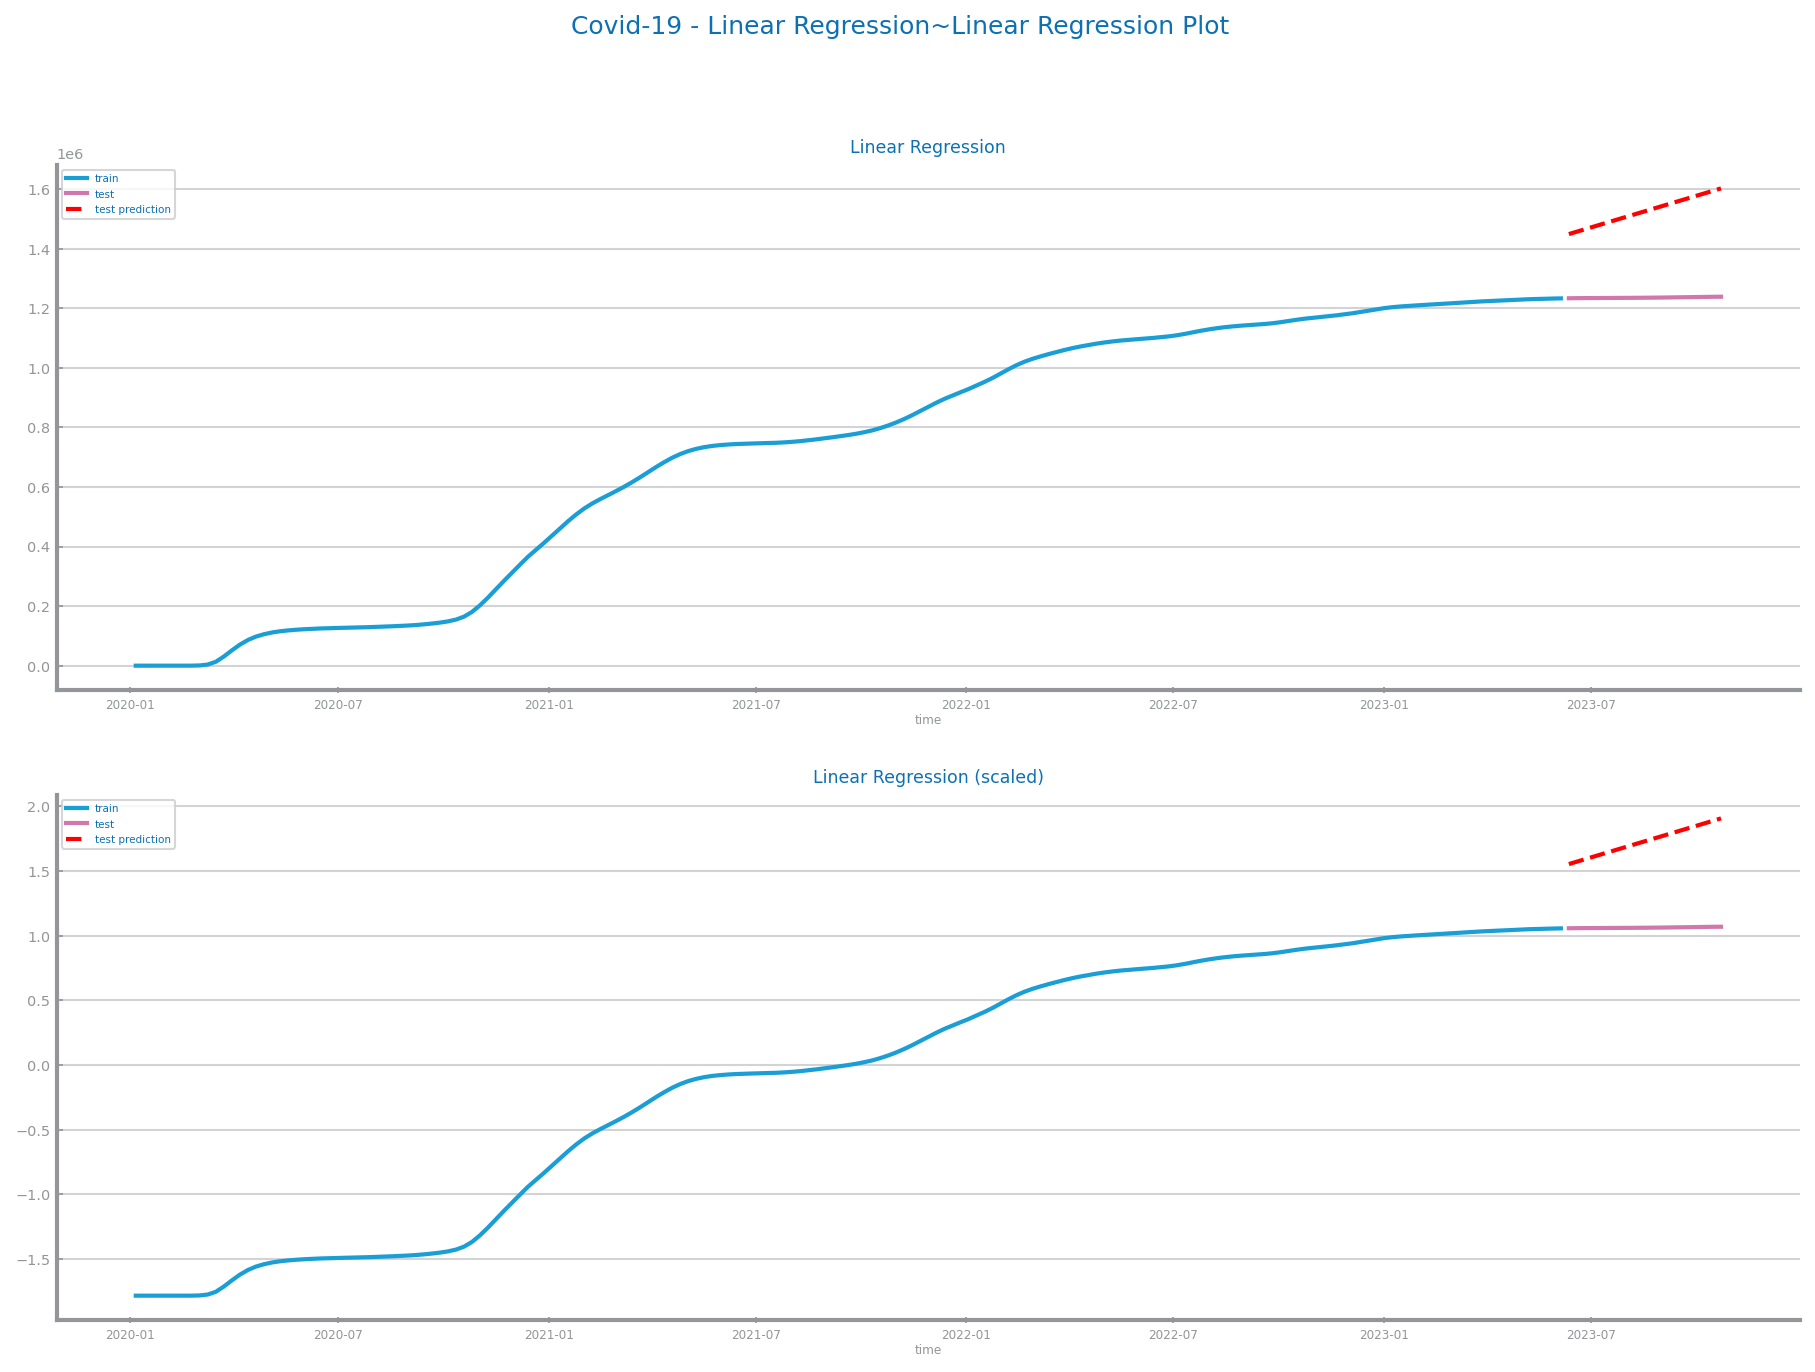

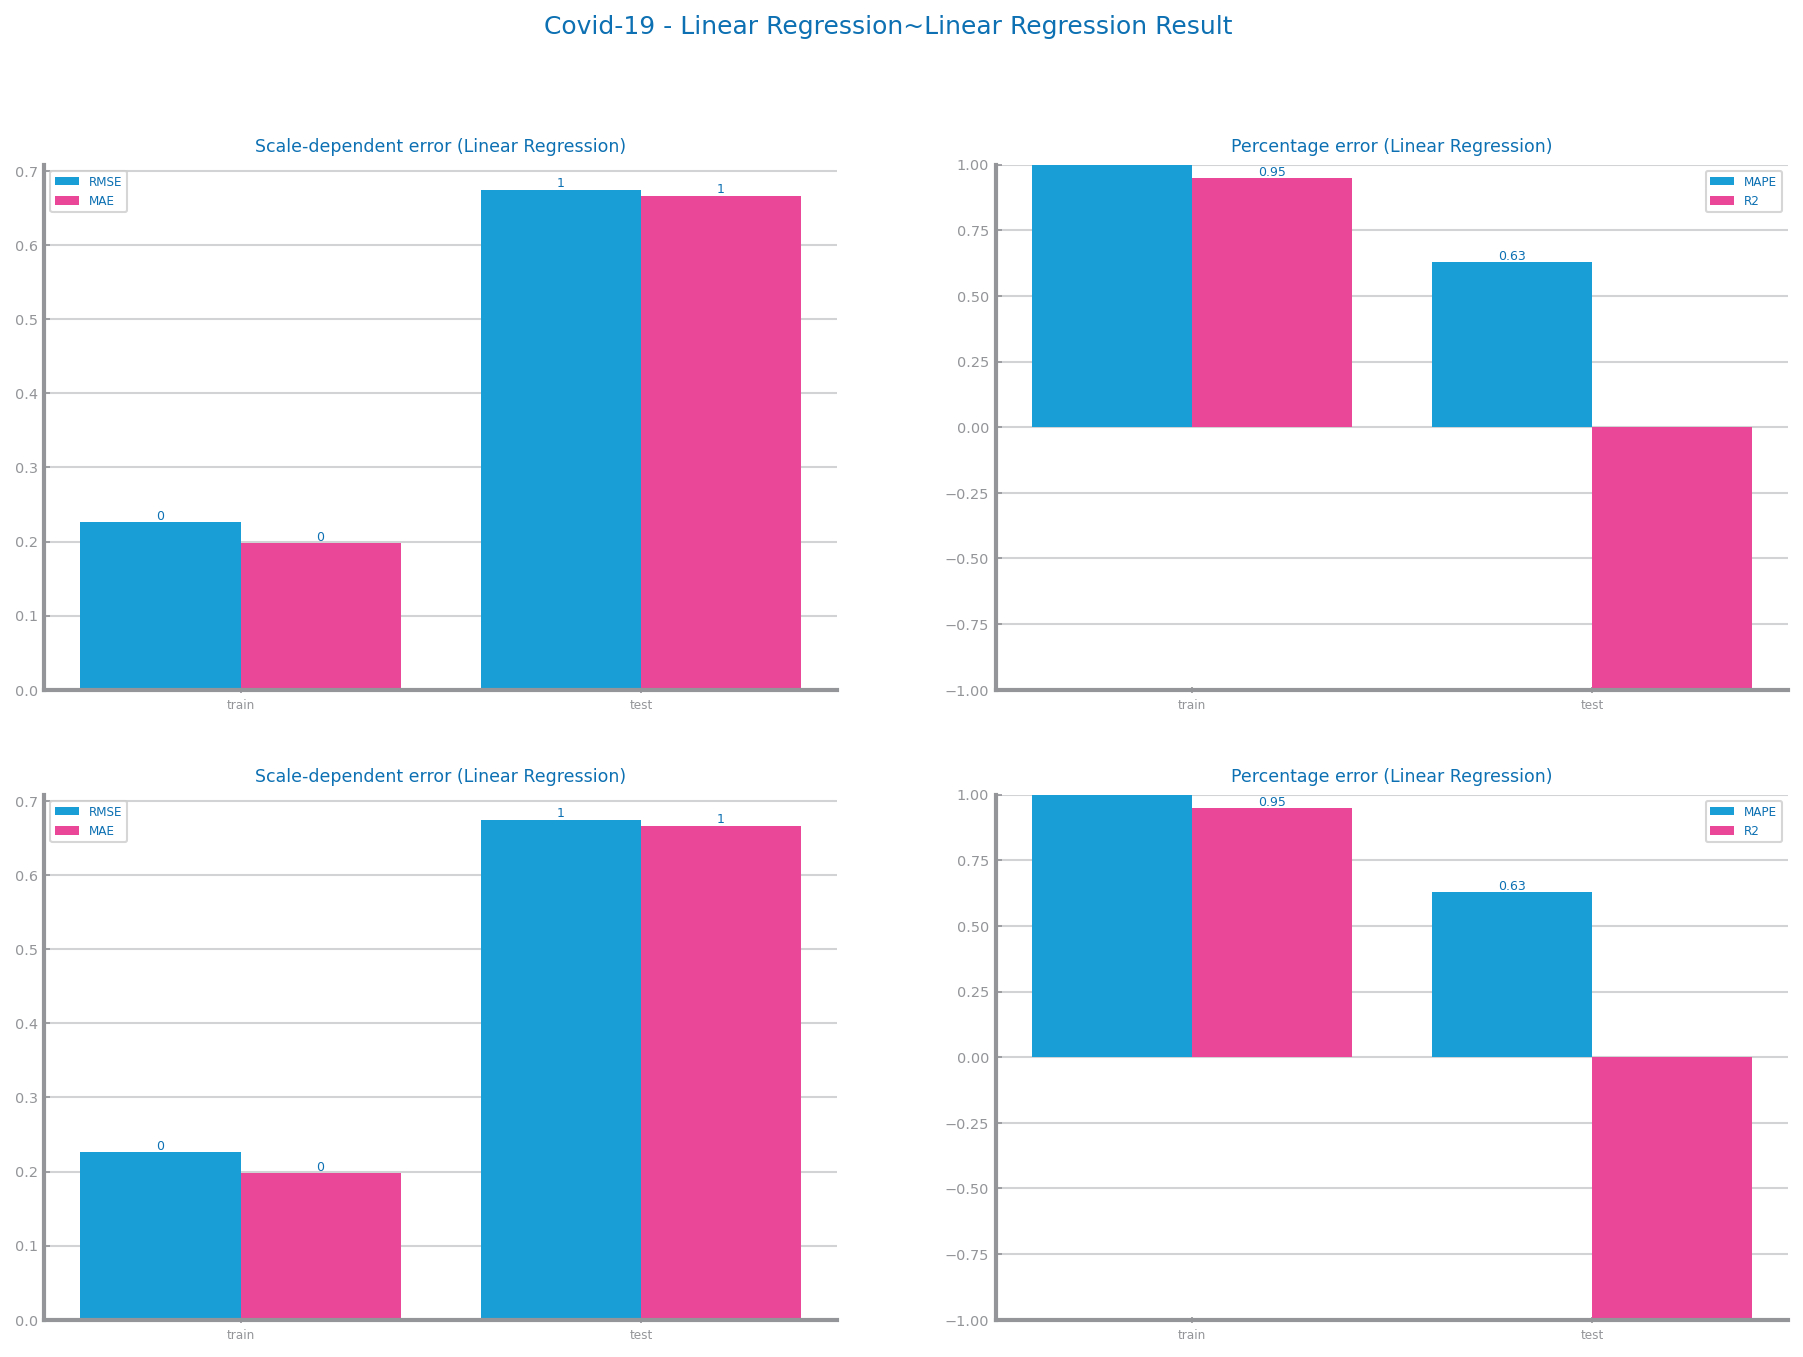

In [20]:
from matplotlib.pyplot import savefig, subplots
from matplotlib.axes import Axes
from matplotlib.figure import Figure

fig: Figure
axs: list[Axes]

model_functions = {
    "Linear Regression": lin,
    "Simple Average": simple,
    "Persistence": persistence_optimist,
    "Persistence Realist": persistence_realist,
    "Rolling Mean": rolling_mean,
    "ARIMA": arima,
    "LSTMs": LSTM,
}


model_list = ["Linear Regression", "Linear Regression"]
measure: str = "R2"

mods_title = ""
[mods_title := mods_title + m + "~" for m in model_list]
mods_title = mods_title[:-1]

df = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
# df = df.rolling(window = 25).mean()
# df.dropna(inplace=True)
# df = df.diff()
# df = df.diff()
# df.dropna(inplace=True)

series: Series = df[target]


if len(model_list) > 1:

    
    fig, axs = subplots(nrows=len(model_list), ncols=1, figsize=(15, 10))
    fig.suptitle(f"{file_tag} - {mods_title} Plot")


    for i in range(len(model_list)):

        title = model_list[i] if len(model_list) > 1 else ""
        if i == 1:
            df: DataFrame = scale_all_dataframe(df)
            title += " (scaled)"
        train, test, prd_trn, prd_tst = model_functions[model_list[i]](df)

        plot_forecasting_series(train, test, prd_tst, ax=axs[i], title=title)
    savefig(f"images/{file_tag}_{mods_title}_plots.png")



    fig2, axs2 = subplots(nrows=len(model_list), ncols=2, figsize=(15, 10))
    fig2.suptitle(f"{file_tag} - {mods_title} Result")

    for i in range(len(model_list)):
        train, test, prd_trn, prd_tst = model_functions[model_list[i]](df)
        title = model_list[i] if len(model_list) > 1 else ""
        plot_forecasting_eval(train, test, prd_trn, prd_tst, axs = axs2[i], title=title)
    savefig(f"images/{file_tag}_{mods_title}_eval.png")
    


elif len(model_list) == 1:
    
    model = model_list[0]

    if model == "ARIMA":
        train, test, prd_trn, prd_tst, best_params = model_functions[model](df)
    else:
        train, test, prd_trn, prd_tst = model_functions[model](df)

    fig, axs = subplots(nrows=1, ncols=1, figsize=(8, 5))
    if model == "ARIMA":
        print(best_params)
        fig.suptitle(f"{file_tag} - {model} Plot (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f})")
    else:
        fig.suptitle(f"{file_tag} - {model} Plot")

    plot_forecasting_series(train, test, prd_tst, ax=axs)
    savefig(f"images/{file_tag}_{model}_plots.png")


    fig, axs = subplots(nrows=1, ncols=2, figsize=(8, 5))
    if model == "ARIMA":
        fig.suptitle(f"{file_tag} - {model} Results (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f})")
    else:
        fig.suptitle(f"{file_tag} - {model} Results")
    
    plot_forecasting_eval(train, test, prd_trn, prd_tst, axs=axs)
    savefig(f"images/{file_tag}_{model}_eval.png")

